<h5><font color='039affff'><b>Part 2</b></font></h5>
In this section, we conduct feature engineering by encoding labels to be used in our machine learning model. We also train 5 models and pick the best one to conduct further analysis

Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
import pickle
import json

from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro
import statsmodels.api as sm

FIrst, let's get the enriched data from the first part

In [20]:
df = pd.read_csv('HDB_resale_prices_enhanced.csv')

<h5><font color='039affff'><b>Feature engineering</b></font></h5>

Since we have all the relevant data needed, we can start the feature engineering process with encoding

In [21]:
print(df.dtypes)

town                             object
flat_type                        object
block                            object
street_name                      object
storey_range                     object
floor_area_sqm                  float64
flat_model                       object
lease_commence_date               int64
remaining_lease                 float64
resale_price                    float64
Distance to reach CBD (km)      float64
latitude                        float64
longitude                       float64
Number of schools within 2km      int64
date_sold                         int64
dtype: object


<b>Midpoint extraction:</b><br>
Used when value has numerical values and order but is in a range<br>
Encoding method: Get midpoint of the range

In [22]:
def apply_midpoint(df, columns):
    for col in columns:
        df[f'{col}_encoded'] = df[col].apply(
            lambda x: np.mean([int(s) for s in str(x).split() if s.isdigit()])
            if pd.notna(x) else None
        )
    return df

df = apply_midpoint(df, ['storey_range'])
print(df['storey_range_encoded'])

0         11.0
1          2.0
2          2.0
3          5.0
4          2.0
          ... 
223884     5.0
223885    11.0
223886     5.0
223887     8.0
223888    11.0
Name: storey_range_encoded, Length: 223889, dtype: float64


Before any further encoding, we should split the dataset into 2: one for training the model and the other to test it. This prevents the model from learning how values are encoded, causing it to be inaccurate

In [ ]:
def prepare_modeling_data(df):
    
    # Extract features and target
    X = df.drop(columns=['resale_price'])
    y = df['resale_price']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        shuffle=True  # Just shuffle, no stratify
    )
    
    # Define cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    
    return X_train, X_test, y_train, y_test, cv

X_train, X_test, y_train, y_test, cv = prepare_modeling_data(df)

Training set: 179111 samples
Testing set: 44778 samples


<b>Label encoding:</b><br>
Creates an integer for each label type found in the column. This is good for columns 'flat_type' and 'flat_model' where the values expected are constant.

In [ ]:
for col in ['town', 'flat_type', 'flat_model']:
    le = LabelEncoder()  # Create encoder
    X_train[f'{col}_encoded'] = le.fit_transform(X_train[col])  
    X_test[f'{col}_encoded'] = le.transform(X_test[col])        

print(X_train[['flat_type', 'flat_type_encoded']].head())

       flat_type  flat_type_encoded
161622    4 ROOM                  3
124201    3 ROOM                  2
7256      4 ROOM                  3
46071     4 ROOM                  3
80241     4 ROOM                  3


<h5><font color='039affff'><b>Predictive modelling</b></font></h5>

The first step is to analyse the correlations between the various features and the resale price. This will tell us which features likely affect the resale price to a greater extent than others. 

In [ ]:
def analyse_correlations(df_train):
    columns = df_train.columns.tolist()
    columns_to_remove = ['_id', 'street_name', 'lease_commence_date', 
                         'flat_type', 'flat_model', 'town', 'storey_range', 'block']
    
    for col in columns_to_remove:
        if col in columns:
            columns.remove(col)
    
    # Calculate correlations with label, sort by strength
    correlations = (df_train[columns]
                   .corr()['resale_price']
                   .sort_values(ascending=False))
    
    return correlations

df_train = X_train.copy()
df_train['resale_price'] = y_train

correlations = analyse_correlations(df_train)
print("\nCorrelations with resale price:")
print(correlations)


Correlations with resale price:
resale_price                    1.000000
flat_type_encoded               0.582953
floor_area_sqm                  0.571814
date_sold                       0.398778
storey_range_encoded            0.341405
remaining_lease                 0.304547
longitude                       0.094420
Number of schools within 2km   -0.013492
town_encoded                   -0.024402
latitude                       -0.164082
Distance to reach CBD (km)     -0.214213
flat_model_encoded             -0.227622
Name: resale_price, dtype: float64


The number of schools within 2km not being a strong feature also agrees with our geospatial analysis done earlier.

However, due to the lack of features available, we will use all the features to train the model.

In [ ]:
features = correlations[1:].index.tolist()  #Exclude resale price
X_train = X_train[features]
X_test = X_test[features]

<h5><font color='039affff'><b>Training the model</b></font></h5>

For this project, I have chosen to try 5 different models and will use the most accurate model for the next steps

The models I chose are linear and tree models, since the result is not binary. The models are:
<ol>
    <li>Linear Regression</li>
    <li>Random Forest</li>
    <li>XGBoost</li>
    <li>LightGBM</li>
    <li>Gradient Boosting</li>
</ol>

For validation, we used R² to measure how well our model explains price variance, and MAE to quantify the average prediction error in dollars.

In [ ]:
def train_base_models(X_train, y_train, cv):    
    
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(
            random_state=42,
            n_estimators=100
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            random_state=42,
            n_jobs=-1
        ),
        'LightGBM': LGBMRegressor(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            random_state=42
        )
    }
    
    cv_results = {} #store results
    
    # Train and evaluate each model using K-fold CV
    for name, model in models.items():
        print(f"\nTraining {name} with 5-fold cross-validation...")
        
        scores = cross_val_score(
            model,
            X_train, 
            y_train,
            cv=cv,
            scoring='r2',
            n_jobs=-1
        )
        
        # Also get MAE scores
        mae_scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring='neg_mean_absolute_error',
            n_jobs=-1
        )
        mae_scores = -mae_scores  # Convert to positive MAE
        
        # Store scores
        cv_results[name] = {
            'r2_scores': scores,
            'mae_scores': mae_scores
        }
        
        print(f"CV R² Score: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        print(f"CV MAE: ${mae_scores.mean():,.0f} (+/- ${mae_scores.std() * 2:,.0f})")
        
        # Fit final model on full training data
        model.fit(X_train, y_train)
        
    return models, cv_results

# Train models with cross-validation
base_models, cv_scores = train_base_models(X_train, y_train, cv)


Training Linear Regression with 5-fold cross-validation...
CV R² Score: 0.8204 (+/- 0.0014)
CV MAE: $60,708 (+/- $375)

Training Random Forest with 5-fold cross-validation...
CV R² Score: 0.9736 (+/- 0.0011)
CV MAE: $21,167 (+/- $175)

Training XGBoost with 5-fold cross-validation...
CV R² Score: 0.9683 (+/- 0.0015)
CV MAE: $24,032 (+/- $253)

Training LightGBM with 5-fold cross-validation...
CV R² Score: 0.9655 (+/- 0.0010)
CV MAE: $25,164 (+/- $256)

Training Gradient Boosting with 5-fold cross-validation...
CV R² Score: 0.9687 (+/- 0.0009)
CV MAE: $23,883 (+/- $135)


Now that we have identified Random Forest as the best performing model, we can use it for in depth analysis

In [ ]:
# Test the best model
best_model = base_models['Random Forest']

#Save model seperately before testing
with open('random_forest_model.pkl', 'wb') as f: 
    pickle.dump(best_model, f)
# Save arrays for fast loading
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

# Save feature names for DataFrames
with open('feature_names.json', 'w') as f:
    json.dump(list(X_train.columns), f, indent=2)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

print("MODEL PERFORMANCE SUMMARY")
print("-" * 40)
residuals = y_test - y_pred

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs(residuals / y_test)) * 100

print(f"📈 R² Score: {r2:.4f}")
print(f"💰 MAE: ${mae:,.0f}")
print(f"📏 RMSE: ${rmse:,.0f}")
print(f"📊 MAPE: {mape:.2f}%")
print(f"📋 Test samples: {len(y_test)}")
print(f"💵 Average test price: ${y_test.mean():,.0f}")
print(f"🎯 Typical error: ${mae:,.0f} ({mae/y_test.mean()*100:.1f}% of price)")

MODEL PERFORMANCE SUMMARY
----------------------------------------
📈 R² Score: 0.9743
💰 MAE: $20,992
📏 RMSE: $29,998
📊 MAPE: 4.06%
📋 Test samples: 44778
💵 Average test price: $527,186
🎯 Typical error: $20,992 (4.0% of price)


Let's break down what each metric means:<ul>

<li>R² Score (0.9743): This indicates that the model explains 97.43% of the variance in HDB resale prices, meaning nearly all the price differences between properties can be accounted for by the features in our model.</li>

<li>MAE ($20,992): The Mean Absolute Error shows that on average, the price predictions differ from actual sale prices by $21,332. </li>

<li>RMSE ($29,998): Root Mean Square Error gives more weight to larger prediction errors, indicating that while most errors cluster around $21k, some predictions deviate more substantially.</li>

<li>MAPE (4.06%): Mean Absolute Percentage Error reveals that our average prediction error represents 4.11% of the actual property price.</li>

<li>Test Samples (44,778): 44,778 properties were used to test the model (20% of the whole dataset).</li>

<li>Average Test Price ($527,186): The mean price of properties in our test set. Used to see how far off our model is.</li>
<li>Typical Error (4.0% of price): This indicates we can predict HDB resale prices within approximately 4% of their actual value on average.</li>

<h5><font color='039affff'><b>Residual analysis</b></font></h5>

Identifying the errors and understanding the patterns helps us understand if they should be a source of concern or are expected. Done by examining the difference between predicted and actual valyes to get check for model assumptions and problems. If patterns exist, they suggest critical errors in the model

<ol><li>Normality test (Shapiro-Wilk):</li> <ul>
    <li>Checks if the data follows a normal distribution by comparing it against what perfectly normal data should look like</li>
    <li>W (statistic) checks how 'normal' the data looks: 0 (not normal) < w < 1 (normal)</li>
    <li>p-value checks how 'normal' the data is statistically: p > 0.05 represents the data following a normal distribution</li></ul>
<li>Q-Q plot</li><ul>
    <li>Compares the data's quantiles vs normal distribution quantiles</li>
    <li>Points above the line: More extreme values than normal</li>
    <li>Points below the line: Lesser extreme values than normal</li></ul>  
<li>Homoscedasticity test</li><ul>
    <li>Flat lines, random or no patterns are good: shows no bias causing inconsistent variance</li>
    <li>Fan shape patterns suggests bias causing errors</li></ul>
<li>Breusch-Pagan test </li><ul>
    <li>Checks if error variance is constant</li>
    <li>The higher the LM score, the 'stronger' the evidence of non constance variance (heteroscedasticity )</li>
    <li>p > 0.05 suggests that variance is constant</li>


Normality Test (Shapiro-Wilk):
w: 0.9502, p-value: 0.000000
Residuals normally distributed? NO


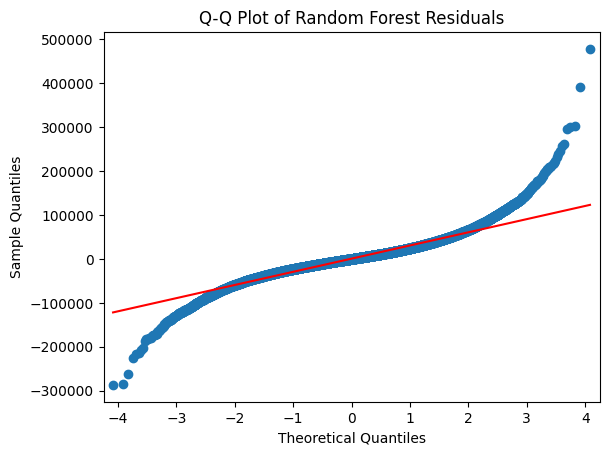

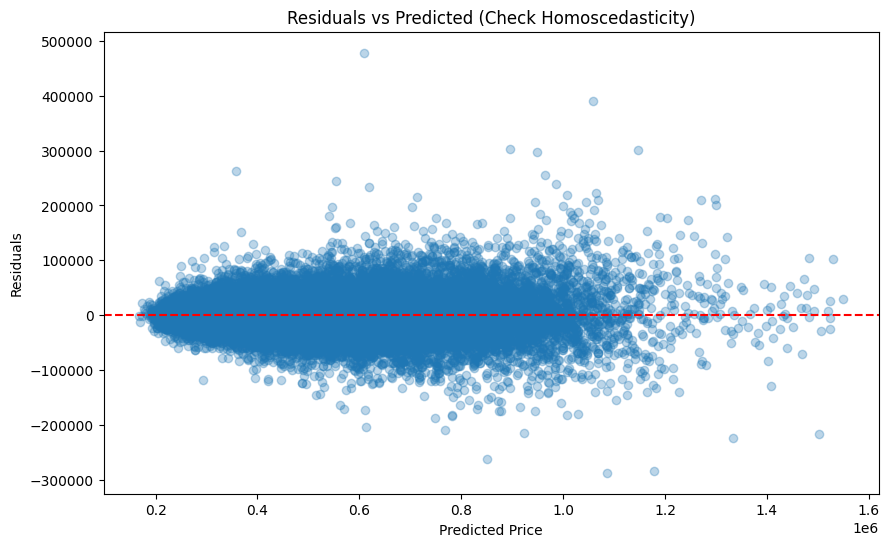


Breusch-Pagan Heteroscedasticity Test:
LM statistic: 2835.815, p-value: 0.000000
Constant variance? NO


In [ ]:
# 1. Normality test (Shapiro-Wilk)
shapiro_stat, shapiro_p = shapiro(residuals[:5000])  # Limit for speed
print(f"\nNormality Test (Shapiro-Wilk):")
print(f"w: {shapiro_stat:.4f}, p-value: {shapiro_p:.6f}")
print(f"Residuals normally distributed? {'YES' if shapiro_p > 0.05 else 'NO'}")

# 2. Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Random Forest Residuals')
plt.show()

# 3. Homoscedasticity test 
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Check Homoscedasticity)')
plt.show()

# 4. Breusch-Pagan test 
X_test_const = sm.add_constant(X_test)
bp_test = het_breuschpagan(residuals, X_test_const)
print(f"\nBreusch-Pagan Heteroscedasticity Test:")
print(f"LM statistic: {bp_test[0]:.3f}, p-value: {bp_test[1]:.6f}")
print(f"Constant variance? {'YES' if bp_test[1] > 0.05 else 'NO'}")

Let's analyse the findings

<ol><li>Normality test (Shapiro-Wilk):</li> <ul>
    <li>Checks if the data follows a normal distribution by comparing it against what perfectly normal data should look like</li>
    <li>Suggests that the data looks normal but statistically isn't</li></ul>
<li>Q-Q plot</li><ul>
    <li>Compares the data's quantiles vs normal distribution quantiles</li>
    <li>S-shaped deviation indicates heavy-tailed residuals</li>
    <li>More extreme residuals than expected under normality</li> </ul>
<li>Residuals vs. Predicted plot</li><ul>
    <li>Flat line, random or no patterns are good: shows no bias</li>
    <li>Errors found showed no bias</li></ul>
<li>Breusch-Pagan test </li><ul>
    <li>Checks if error variance is constant</li>
    <li>Strong evidence that error variance is not constant</li></ul></ol>

The errors did not show systemic bias, accurately reflecting the characteristics of the housing market. Suggests heteroscedasticity, a pattern in housing markets where high priced homes have more variable pricing

<h5><font color='039affff'><b>Conclusion</b></font></h5>
We have successfully created a machine learning model to predict HDB prices. Additionally, the errors found (since it is impossible to have a 100% accurate model) showed no bias, suggesting that the machine learning process was done correctly.

Refer to part 3 for the resale price analysis